
# Alzheimer's MRI Classification — Model Comparison Study

This notebook auto-discovers metric files, loads their training and evaluation statistics, and produces:

- A consolidated **summary table** of key metrics across models  
- **Training curves** (accuracy, loss, validation accuracy, validation loss)  
- **Learning-rate** schedules  
- **Per-class** precision/recall/F1 comparisons across models  
- **Confusion matrices** for each model  
- **Prediction distribution vs. class support** checks for imbalance/over/under-prediction  
- A **best-by-metric** report (e.g., top test accuracy, top macro F1, etc.)  

> Tip: Drop any number of `*_metrics.json` files in the `metrics/` folder and re-run all cells.


In [1]:

import json
import os
import glob
from typing import Dict, Any, List
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Display settings
pd.set_option("display.max_rows", 200)
pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 200)

# Notebook parameters
METRICS_GLOB = "metrics/*_metrics.json"

def load_metrics_files(pattern: str = METRICS_GLOB) -> List[Dict[str, Any]]:
    paths = sorted(glob.glob(pattern))
    data = []
    for p in paths:
        try:
            with open(p, "r", encoding="utf-8") as f:
                d = json.load(f)
            d["_file"] = p
            data.append(d)
        except Exception as e:
            print(f"[WARN] Failed to load {p}: {e}")
    if not data:
        print(f"[WARN] No files matched {pattern}. Place *_metrics.json files under metrics/.")
    else:
        print(f"Loaded {len(data)} file(s):")
        for d in data:
            print(" -", d.get('_file'))
    return data

metrics_data = load_metrics_files()


Loaded 20 file(s):
 - metrics\DenseNet121_metrics.json
 - metrics\DenseNet201_metrics.json
 - metrics\EfficientNetB0_metrics.json
 - metrics\InceptionResNetV2_metrics.json
 - metrics\InceptionV3_metrics.json
 - metrics\MobileNetV2_metrics.json
 - metrics\NASNetLarge_metrics.json
 - metrics\ResNet101_metrics.json
 - metrics\ResNet50_metrics.json
 - metrics\VGG16_metrics.json
 - metrics\VGG19_metrics.json
 - metrics\ViT-B16-fe_metrics.json
 - metrics\ViT-B32-fe_metrics.json
 - metrics\ViT-B8-fe_metrics.json
 - metrics\ViT-L16-fe_metrics.json
 - metrics\ViT-R26-S32-lightaug-fe_metrics.json
 - metrics\ViT-R26-S32-medaug-fe_metrics.json
 - metrics\ViT-S16-fe_metrics.json
 - metrics\ViT-b16_metrics.json
 - metrics\Xception_metrics.json


In [2]:

# Peek keys (first file) for sanity
if metrics_data:
    first = metrics_data[0]
    print("Example model:", first.get("model_name"))
    print("Top-level keys:", list(first.keys()))
    print("Training history keys:", list(first.get("training_history", {}).keys()))
    print("Evaluation keys:", list(first.get("evaluation_metrics", {}).keys()))
    print("Training info:", first.get("training_info", {}))


Example model: DenseNet121
Top-level keys: ['model_name', 'training_history', 'evaluation_metrics', 'training_info', '_file']
Training history keys: ['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate']
Evaluation keys: ['model_name', 'test_accuracy', 'classification_report_dict', 'classification_report_str', 'confusion_matrix', 'class_names', 'num_test_samples', 'predictions_confidence', 'prediction_distribution']
Training info: {'total_epochs': 50, 'best_val_accuracy': 0.6867088675498962, 'best_val_loss': 0.8152776956558228, 'final_train_accuracy': 0.5898366570472717, 'final_train_loss': 0.9363858699798584}


In [3]:

def extract_summary_rows(data: List[Dict[str, Any]]) -> pd.DataFrame:
    rows = []
    for d in data:
        name = d.get("model_name") or d.get("evaluation_metrics", {}).get("model_name") or os.path.basename(d.get("_file", "unknown"))
        ev = d.get("evaluation_metrics", {})
        cr = ev.get("classification_report_dict", {}) or {}
        macro = cr.get("macro avg", {})
        weighted = cr.get("weighted avg", {})
        acc = ev.get("test_accuracy", cr.get("accuracy"))

        tr_info = d.get("training_info", {})
        total_epochs = tr_info.get("total_epochs")
        best_val_acc = tr_info.get("best_val_accuracy")
        best_val_loss = tr_info.get("best_val_loss")
        final_train_acc = tr_info.get("final_train_accuracy")
        final_train_loss = tr_info.get("final_train_loss")

        rows.append({
            "model": name,
            "test_accuracy": acc,
            "macro_precision": macro.get("precision"),
            "macro_recall": macro.get("recall"),
            "macro_f1": macro.get("f1-score"),
            "weighted_precision": weighted.get("precision"),
            "weighted_recall": weighted.get("recall"),
            "weighted_f1": weighted.get("f1-score"),
            "num_test_samples": ev.get("num_test_samples"),
            "total_epochs": total_epochs,
            "best_val_accuracy": best_val_acc,
            "best_val_loss": best_val_loss,
            "final_train_accuracy": final_train_acc,
            "final_train_loss": final_train_loss,
            "_file": d.get("_file")
        })
    df = pd.DataFrame(rows).sort_values(by=["test_accuracy","macro_f1"], ascending=[False, False])
    return df.reset_index(drop=True)

summary_df = extract_summary_rows(metrics_data) if metrics_data else pd.DataFrame()
summary_df


,model,test_accuracy,macro_precision,macro_recall,macro_f1,weighted_precision,weighted_recall,weighted_f1,num_test_samples,total_epochs,best_val_accuracy,best_val_loss,final_train_accuracy,final_train_loss,_file
0,ViT-B8-fe,0.759494,0.751042,0.762171,0.752358,0.748840,0.759494,0.749872,158,48,0.743671,0.650161,0.833938,0.388252,metrics\ViT-B8-fe_metrics.json
1,Xception,0.753165,0.755117,0.755263,0.753360,0.754373,0.753165,0.751957,158,50,0.715190,0.768343,0.780399,0.597360,metrics\Xception_metrics.json
2,ViT-L16-fe,0.746835,0.765652,0.749342,0.753696,0.763027,0.746835,0.751085,158,36,0.772152,0.569421,0.813975,0.422423,metrics\ViT-L16-fe_metrics.json
3,ViT-B16-fe,0.740506,0.736347,0.743421,0.737052,0.734517,0.740506,0.734672,158,38,0.759494,0.564307,0.882033,0.274582,metrics\ViT-B16-fe_metrics.json
4,ViT-S16-fe,0.740506,0.732571,0.743750,0.735502,0.730912,0.740506,0.733081,158,28,0.737342,0.683830,0.924682,0.192126,metrics\ViT-S16-fe_metrics.json
5,ViT-B32-fe,0.740506,0.729245,0.743750,0.734399,0.727290,0.740506,0.731818,158,27,0.756329,0.642205,0.924682,0.194201,metrics\ViT-B32-fe_metrics.json
6,NASNetLarge,0.727848,0.724456,0.730263,0.726297,0.722821,0.727848,0.724275,158,50,0.689873,0.808869,0.820327,0.510328,metrics\NASNetLarge_metrics.json
7,ViT-b16,0.727848,0.733525,0.729934,0.720200,0.731774,0.727848,0.718137,158,47,0.718354,0.665786,0.812160,0.443663,metrics\ViT-b16_metrics.json
8,MobileNetV2,0.721519,0.711711,0.724342,0.713932,0.709605,0.721519,0.711432,158,40,0.731013,0.740965,0.725953,0.680242,metrics\MobileNetV2_metrics.json
9,DenseNet201,0.715190,0.703944,0.718750,0.707012,0.700830,0.715190,0.703628,158,50,0.718354,0.731237,0.709619,0.727725,metrics\DenseNet201_metrics.json


In [4]:

if not summary_df.empty:
    out_csv = "model_comparison_summary.csv"
    summary_df.to_csv(out_csv, index=False)
    print(f"Saved summary to {out_csv}")
else:
    print("No summary to save.")


Saved summary to model_comparison_summary.csv


In [5]:

def get_best(df: pd.DataFrame, metric: str) -> pd.DataFrame:
    if metric not in df.columns or df.empty:
        return pd.DataFrame()
    top = df.sort_values(metric, ascending=False).head(3).reset_index(drop=True)
    return top[["model", metric, "_file"]]

if not summary_df.empty:
    metrics_to_rank = ["test_accuracy", "macro_f1", "macro_precision", "macro_recall", "weighted_f1"]
    for m in metrics_to_rank:
        print(f"\nTop-3 by {m}:")
        display(get_best(summary_df, m))



Top-3 by test_accuracy:


,model,test_accuracy,_file
0,ViT-B8-fe,0.759494,metrics\ViT-B8-fe_metrics.json
1,Xception,0.753165,metrics\Xception_metrics.json
2,ViT-L16-fe,0.746835,metrics\ViT-L16-fe_metrics.json



Top-3 by macro_f1:


,model,macro_f1,_file
0,ViT-L16-fe,0.753696,metrics\ViT-L16-fe_metrics.json
1,Xception,0.753360,metrics\Xception_metrics.json
2,ViT-B8-fe,0.752358,metrics\ViT-B8-fe_metrics.json



Top-3 by macro_precision:


,model,macro_precision,_file
0,ViT-L16-fe,0.765652,metrics\ViT-L16-fe_metrics.json
1,Xception,0.755117,metrics\Xception_metrics.json
2,ViT-B8-fe,0.751042,metrics\ViT-B8-fe_metrics.json



Top-3 by macro_recall:


,model,macro_recall,_file
0,ViT-B8-fe,0.762171,metrics\ViT-B8-fe_metrics.json
1,Xception,0.755263,metrics\Xception_metrics.json
2,ViT-L16-fe,0.749342,metrics\ViT-L16-fe_metrics.json



Top-3 by weighted_f1:


,model,weighted_f1,_file
0,Xception,0.751957,metrics\Xception_metrics.json
1,ViT-L16-fe,0.751085,metrics\ViT-L16-fe_metrics.json
2,ViT-B8-fe,0.749872,metrics\ViT-B8-fe_metrics.json


## Training & Validation Curves (Combined)

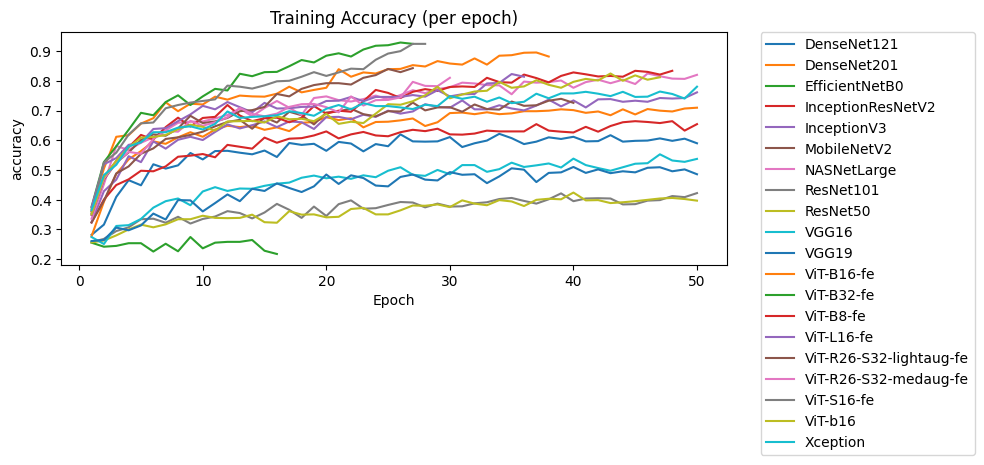

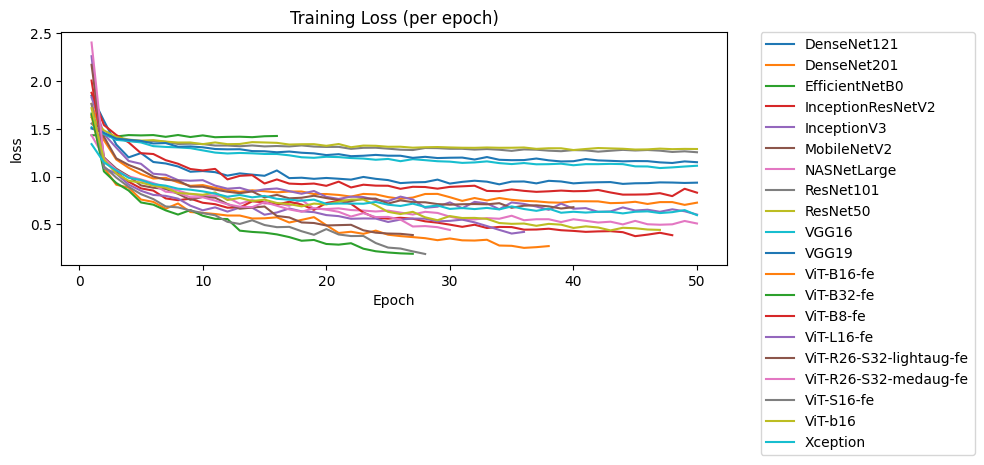

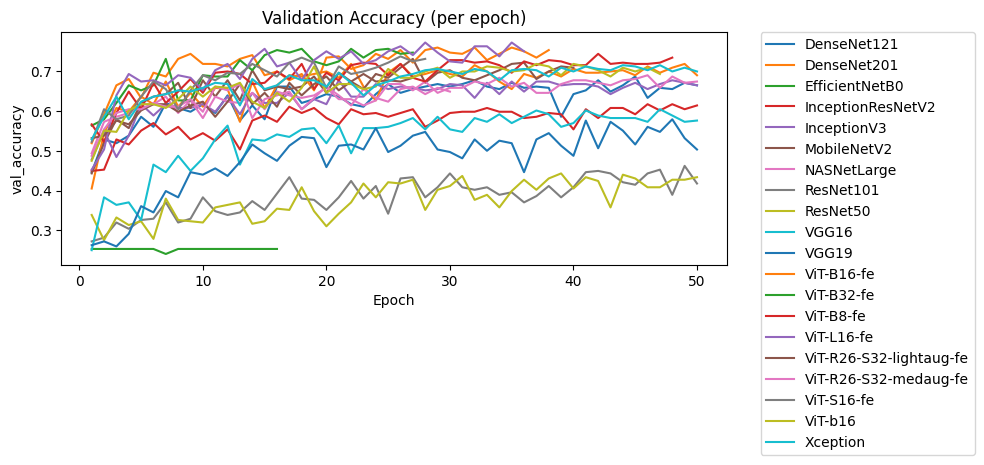

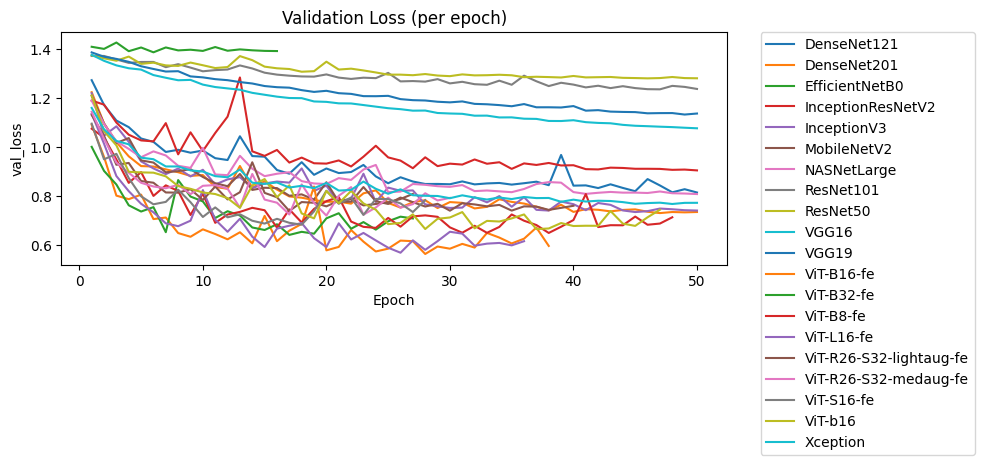

In [6]:
def plot_combined_curve(data, key: str, title: str, ylabel: str):
    if not data:
        print("No data to plot.")
        return
    plt.figure(figsize=(10, 4))
    for d in data:
        name = d.get("model_name") or os.path.basename(d.get("_file", "unknown"))
        y = d.get("training_history", {}).get(key, [])
        if y:
            plt.plot(range(1, len(y)+1), y, label=name)
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.legend(loc="best", bbox_to_anchor=(1.05, 1), borderaxespad=0.)
    plt.tight_layout()
    plt.show()

plot_combined_curve(metrics_data, "accuracy", "Training Accuracy (per epoch)", "accuracy")
plot_combined_curve(metrics_data, "loss", "Training Loss (per epoch)", "loss")
plot_combined_curve(metrics_data, "val_accuracy", "Validation Accuracy (per epoch)", "val_accuracy")
plot_combined_curve(metrics_data, "val_loss", "Validation Loss (per epoch)", "val_loss")


## Learning Rate Schedules

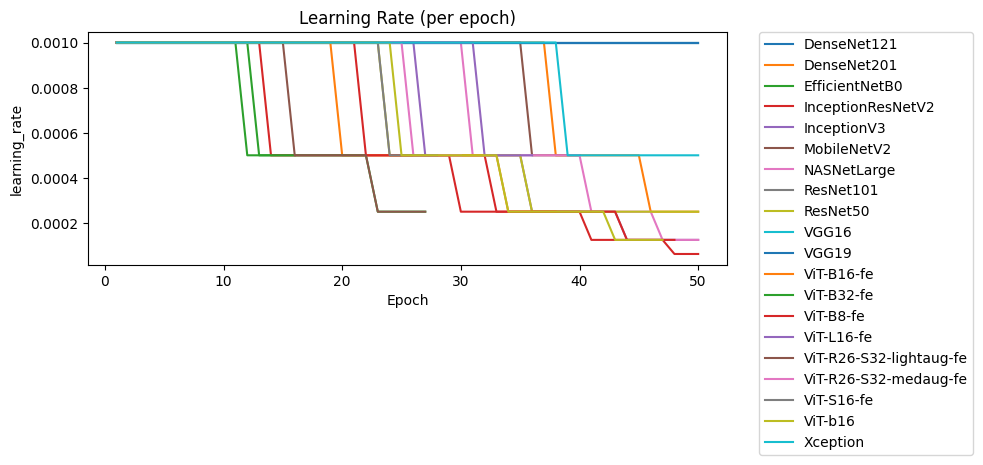

In [7]:

plot_combined_curve(metrics_data, "learning_rate", "Learning Rate (per epoch)", "learning_rate")


## Per-class Metrics — Cross-model Comparison

,DenseNet121,DenseNet201,EfficientNetB0,InceptionResNetV2,InceptionV3,MobileNetV2,NASNetLarge,ResNet101,ResNet50,VGG16,VGG19,ViT-B16-fe,ViT-B32-fe,ViT-B8-fe,ViT-L16-fe,ViT-R26-S32-lightaug-fe,ViT-R26-S32-medaug-fe,ViT-S16-fe,ViT-b16,Xception
MildDemented,0.641026,0.692308,0.000000,0.551020,0.600000,0.700000,0.763158,0.267857,0.304348,0.487179,0.526316,0.673913,0.707317,0.687500,0.659574,0.651163,0.630435,0.771429,0.596491,0.742857
ModerateDemented,0.760870,0.950000,0.000000,0.731707,0.785714,0.878049,0.853659,0.642857,0.440000,0.736842,0.684211,0.880952,0.883721,0.925000,0.972973,0.945946,0.840909,0.863636,0.871795,0.813953
NonDemented (2),0.810811,0.673469,0.000000,0.697674,0.767442,0.702128,0.697674,0.517857,0.400000,0.850000,0.562500,0.861111,0.780488,0.825000,0.906250,0.727273,0.755556,0.767442,0.888889,0.868421
VeryMildDemented,0.500000,0.500000,0.253165,0.480000,0.571429,0.566667,0.583333,0.343750,0.285714,0.390244,0.444444,0.529412,0.545455,0.566667,0.523810,0.441176,0.521739,0.527778,0.576923,0.595238


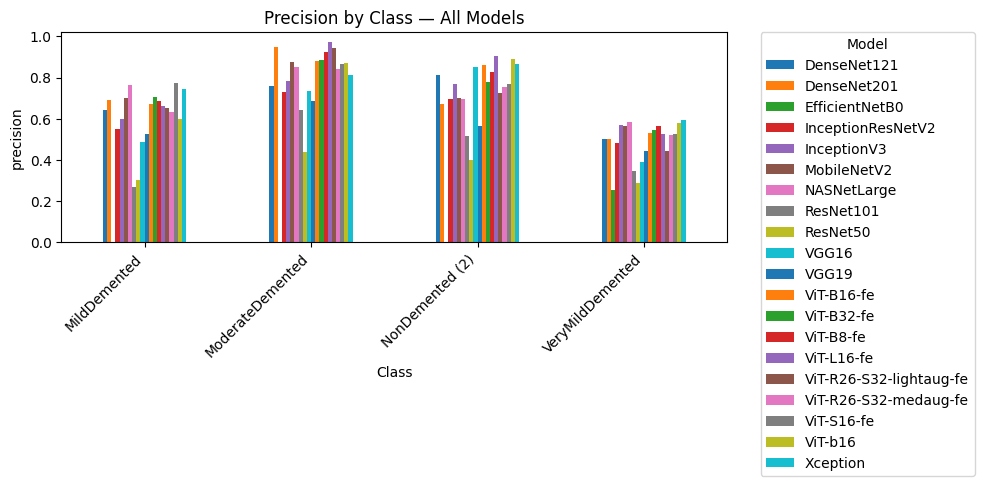

,DenseNet121,DenseNet201,EfficientNetB0,InceptionResNetV2,InceptionV3,MobileNetV2,NASNetLarge,ResNet101,ResNet50,VGG16,VGG19,ViT-B16-fe,ViT-B32-fe,ViT-B8-fe,ViT-L16-fe,ViT-R26-S32-lightaug-fe,ViT-R26-S32-medaug-fe,ViT-S16-fe,ViT-b16,Xception
MildDemented,0.625000,0.675,0.0,0.675000,0.675000,0.700000,0.725000,0.375000,0.350000,0.475000,0.500000,0.775000,0.725,0.825000,0.775000,0.700000,0.725000,0.675,0.850000,0.650000
ModerateDemented,0.921053,1.000,0.0,0.789474,0.868421,0.947368,0.921053,0.236842,0.289474,0.736842,0.684211,0.973684,1.000,0.973684,0.947368,0.921053,0.973684,1.000,0.894737,0.921053
NonDemented (2),0.750000,0.825,0.0,0.750000,0.825000,0.825000,0.750000,0.725000,0.800000,0.850000,0.900000,0.775000,0.800,0.825000,0.725000,0.800000,0.850000,0.825,0.800000,0.825000
VeryMildDemented,0.450000,0.375,1.0,0.300000,0.400000,0.425000,0.525000,0.275000,0.050000,0.400000,0.200000,0.450000,0.450,0.425000,0.550000,0.375000,0.300000,0.475,0.375000,0.625000


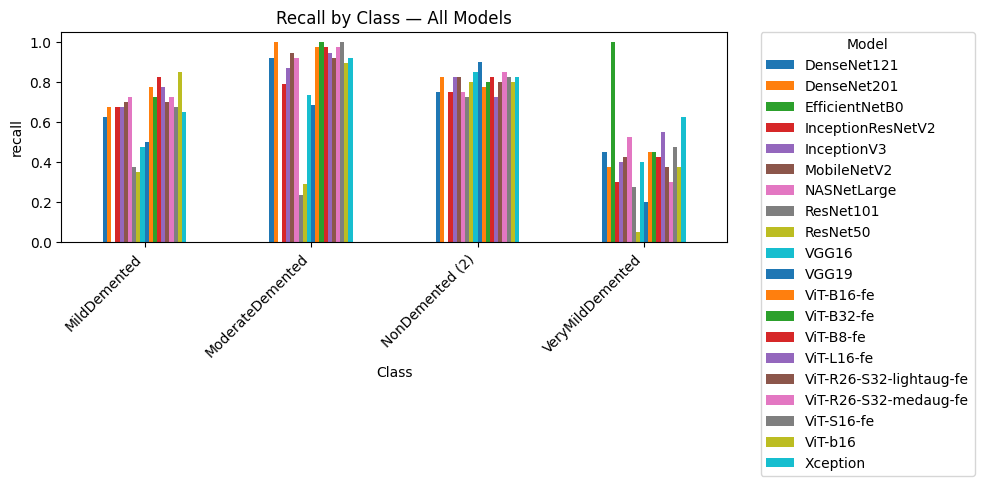

,DenseNet121,DenseNet201,EfficientNetB0,InceptionResNetV2,InceptionV3,MobileNetV2,NASNetLarge,ResNet101,ResNet50,VGG16,VGG19,ViT-B16-fe,ViT-B32-fe,ViT-B8-fe,ViT-L16-fe,ViT-R26-S32-lightaug-fe,ViT-R26-S32-medaug-fe,ViT-S16-fe,ViT-b16,Xception
MildDemented,0.632911,0.683544,0.00000,0.606742,0.635294,0.700000,0.743590,0.312500,0.325581,0.481013,0.512821,0.720930,0.716049,0.750000,0.712644,0.674699,0.674419,0.720000,0.701031,0.693333
ModerateDemented,0.833333,0.974359,0.00000,0.759494,0.825000,0.911392,0.886076,0.346154,0.349206,0.736842,0.684211,0.925000,0.938272,0.948718,0.960000,0.933333,0.902439,0.926829,0.883117,0.864198
NonDemented (2),0.779221,0.741573,0.00000,0.722892,0.795181,0.758621,0.722892,0.604167,0.533333,0.850000,0.692308,0.815789,0.790123,0.825000,0.805556,0.761905,0.800000,0.795181,0.842105,0.846154
VeryMildDemented,0.473684,0.428571,0.40404,0.369231,0.470588,0.485714,0.552632,0.305556,0.085106,0.395062,0.275862,0.486486,0.493151,0.485714,0.536585,0.405405,0.380952,0.500000,0.454545,0.609756


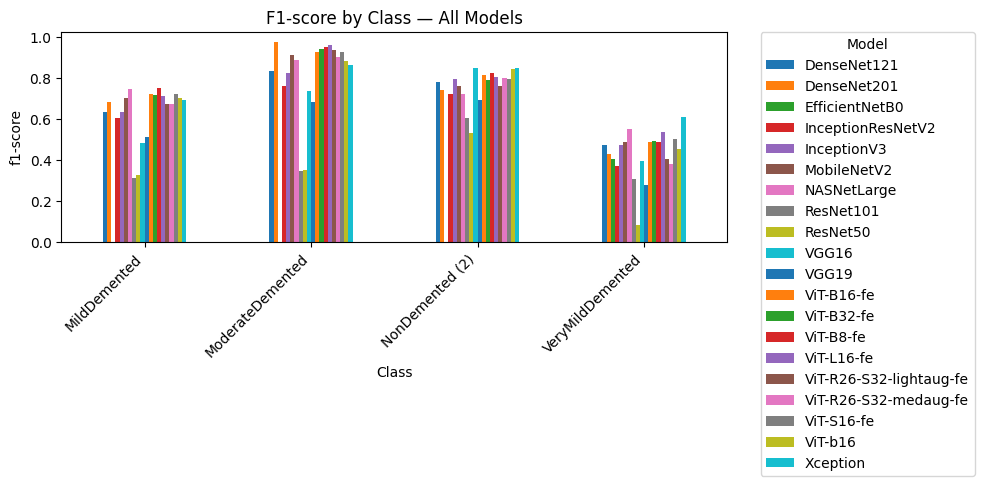

In [8]:

def collect_per_class_metric(data, metric_key: str) -> pd.DataFrame:
    r"""
    Returns a DataFrame indexed by class with columns for each model's metric.
    metric_key in {"precision","recall","f1-score"}
    r"""
    rows = {}
    classes = set()
    models = []
    for d in data:
        name = d.get("model_name") or os.path.basename(d.get("_file","unknown"))
        models.append(name)
        cr = d.get("evaluation_metrics",{}).get("classification_report_dict",{})
        for cls, vals in cr.items():
            if cls in ["accuracy", "macro avg", "weighted avg"]:
                continue
            classes.add(cls)
    classes = sorted(list(classes))
    df = pd.DataFrame(index=classes, columns=models, dtype=float)
    for d in data:
        name = d.get("model_name") or os.path.basename(d.get("_file","unknown"))
        cr = d.get("evaluation_metrics",{}).get("classification_report_dict",{})
        for cls in classes:
            val = cr.get(cls,{}).get(metric_key, np.nan)
            df.loc[cls, name] = val
    return df

if metrics_data:
    for m in ["precision","recall","f1-score"]:
        df_metric = collect_per_class_metric(metrics_data, m)
        display(df_metric)
        # One plot per metric (no subplots)
        plt.figure(figsize=(10, 4))
        ax = df_metric.plot(kind="bar", ax=plt.gca())
        plt.title(f"{m.capitalize()} by Class — All Models")
        plt.xlabel("Class")
        plt.ylabel(m)
        plt.xticks(rotation=45, ha="right")
        plt.legend(title="Model", loc="best", bbox_to_anchor=(1.05, 1), borderaxespad=0.)
        plt.tight_layout()
        plt.show()
else:
    print("No metrics data available.")


## Confusion Matrices

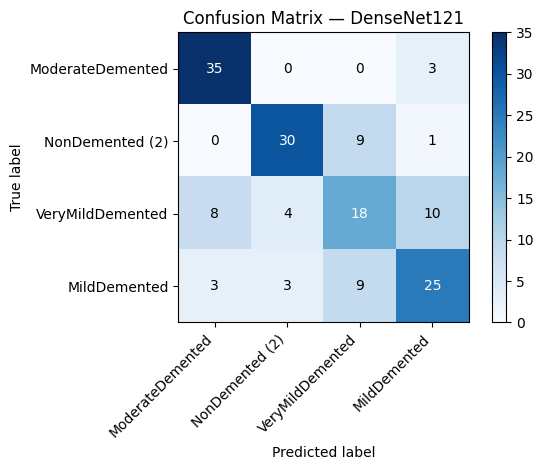

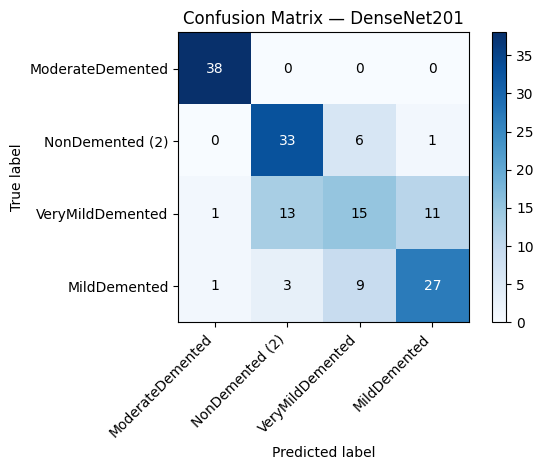

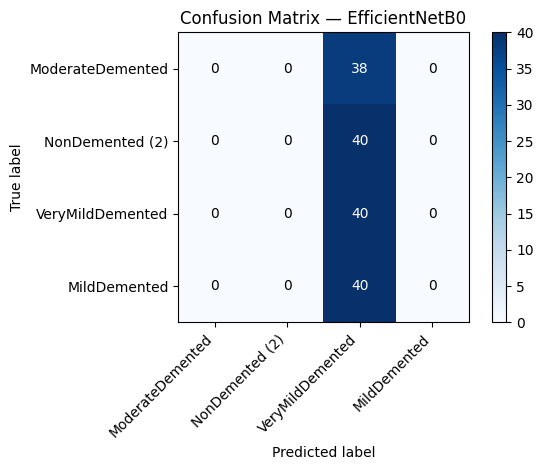

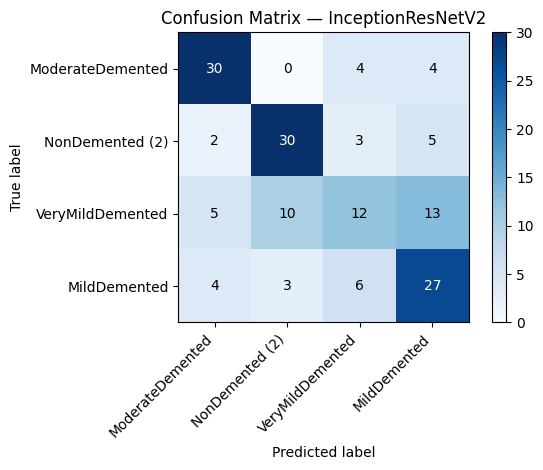

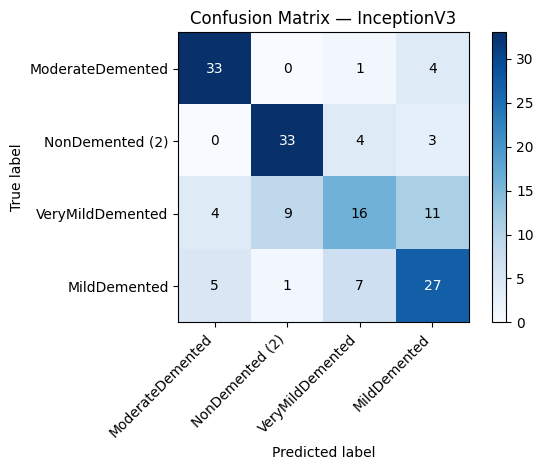

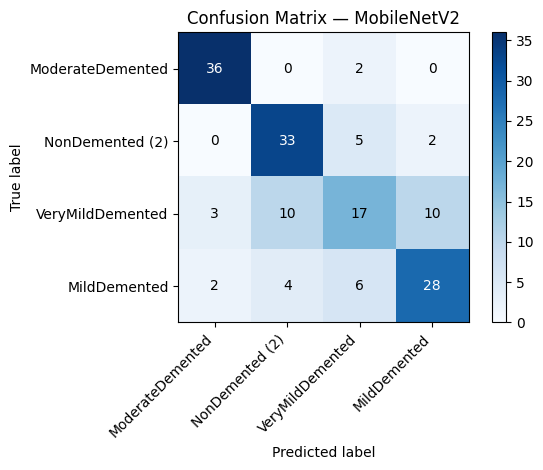

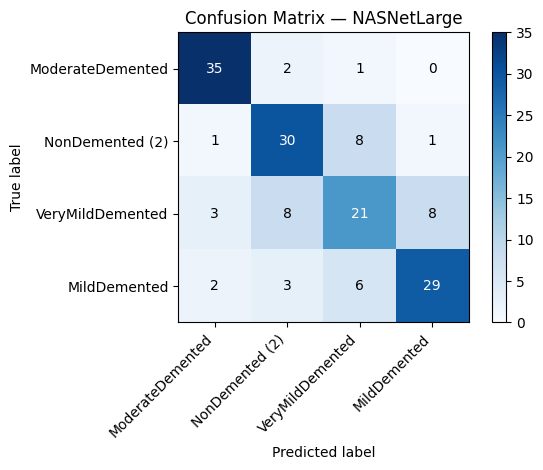

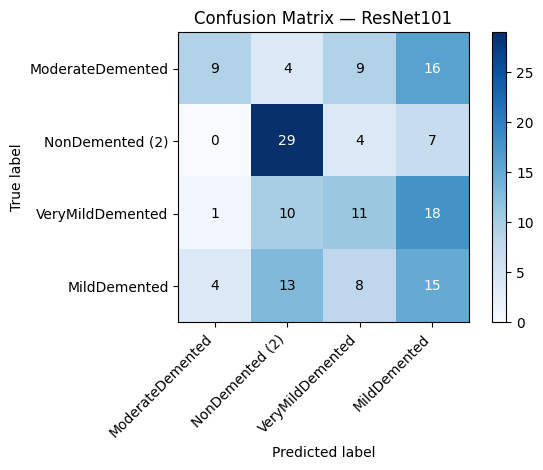

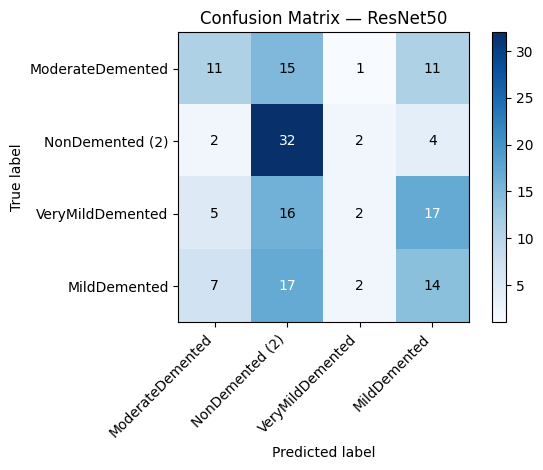

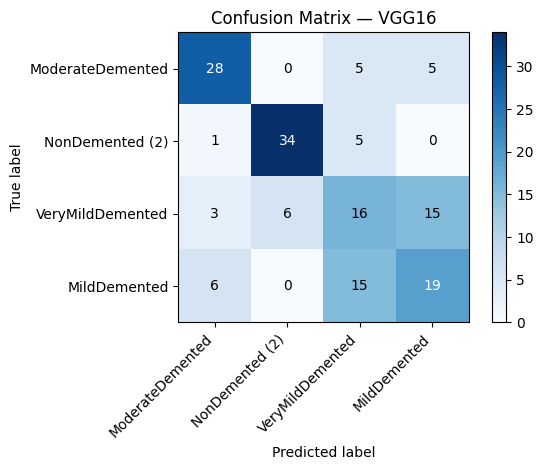

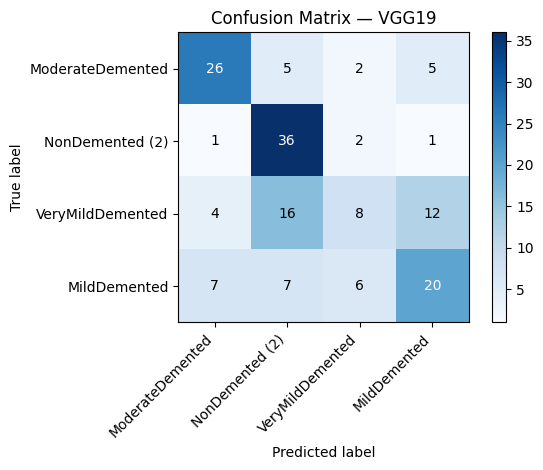

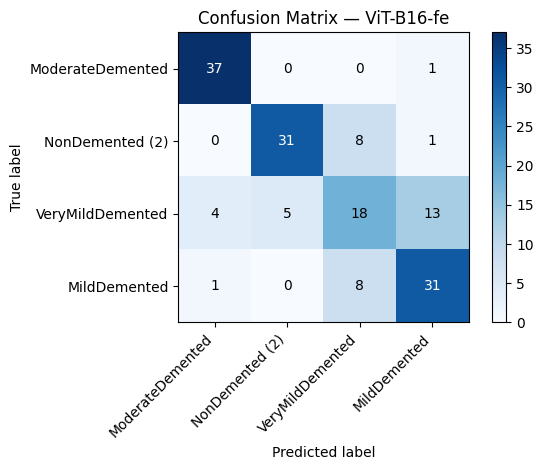

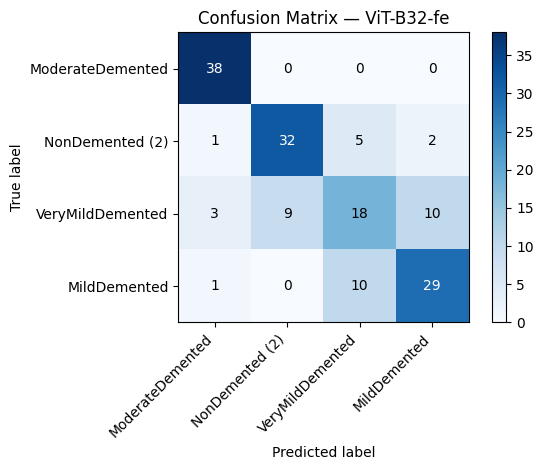

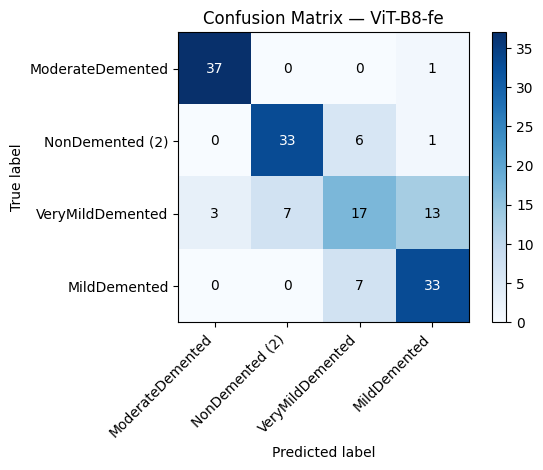

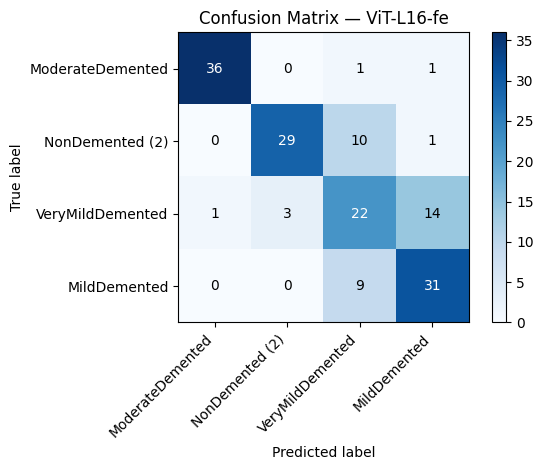

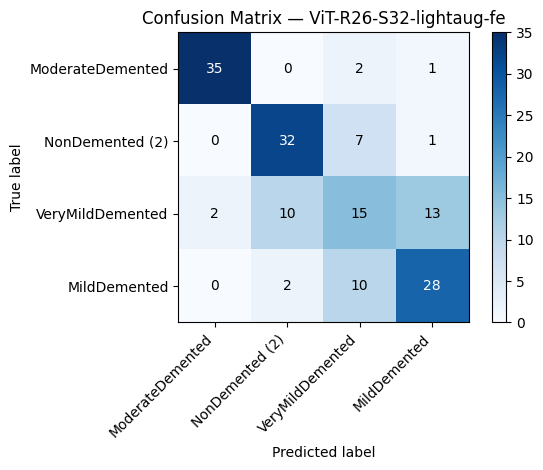

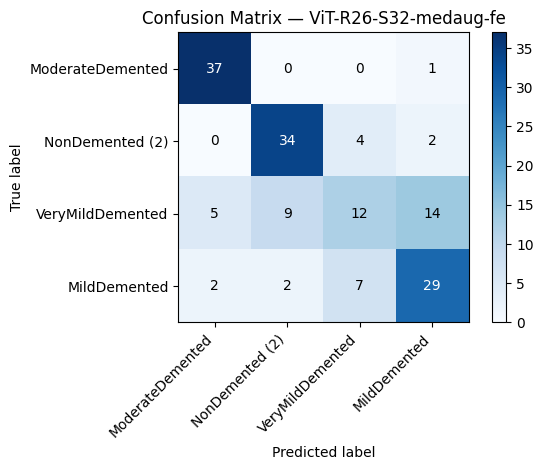

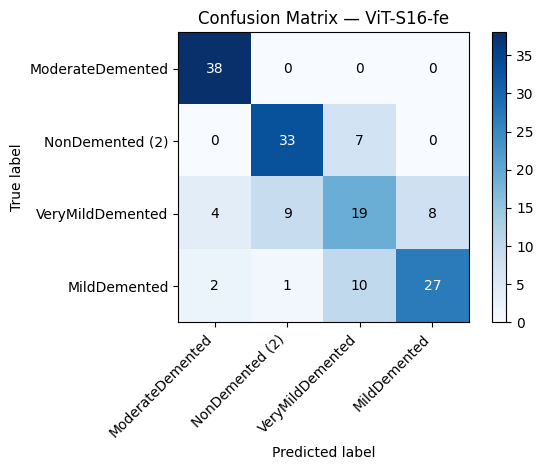

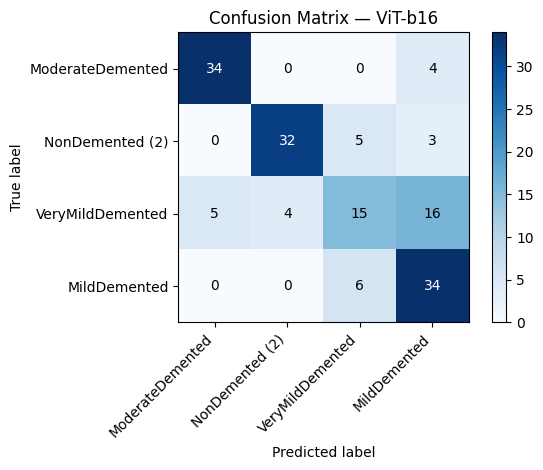

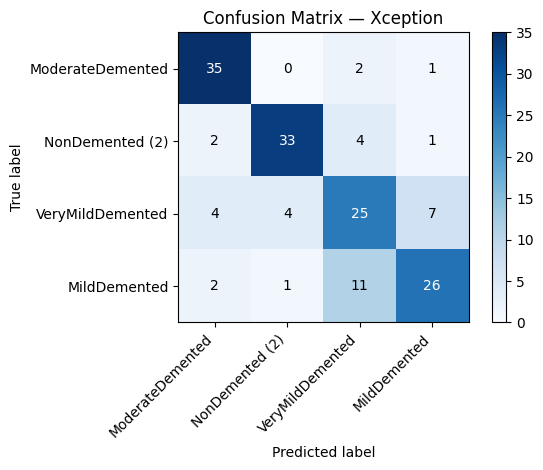

In [9]:

def plot_confusion_matrix(cm, class_names, title):
    plt.figure()
    cm = np.array(cm)
    plt.imshow(cm, interpolation="nearest", cmap="Blues")
    plt.title(title)
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45, ha="right")
    plt.yticks(tick_marks, class_names)
    # Annotate counts
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, str(cm[i, j]), ha="center", va="center", color="white" if cm[i, j] > cm.max()/2 else "black")
    plt.tight_layout()
    plt.show()

for d in metrics_data:
    ev = d.get("evaluation_metrics", {})
    cm = ev.get("confusion_matrix")
    names = ev.get("class_names", [])
    title = f"Confusion Matrix — {d.get('model_name', os.path.basename(d.get('_file','unknown')))}"
    if cm is not None and names:
        plot_confusion_matrix(cm, names, title)
    else:
        print(f"[WARN] Missing confusion matrix for {d.get('model_name', d.get('_file'))}.")


## Prediction Distribution vs. True Support

,predicted_count,true_support
MildDemented,39,40
ModerateDemented,46,38
NonDemented (2),37,40
VeryMildDemented,36,40


<Figure size 640x480 with 0 Axes>

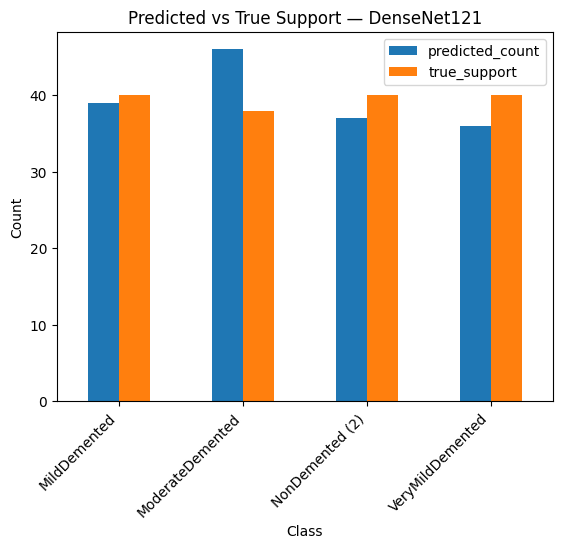

,predicted_count,true_support
MildDemented,39,40
ModerateDemented,40,38
NonDemented (2),49,40
VeryMildDemented,30,40


<Figure size 640x480 with 0 Axes>

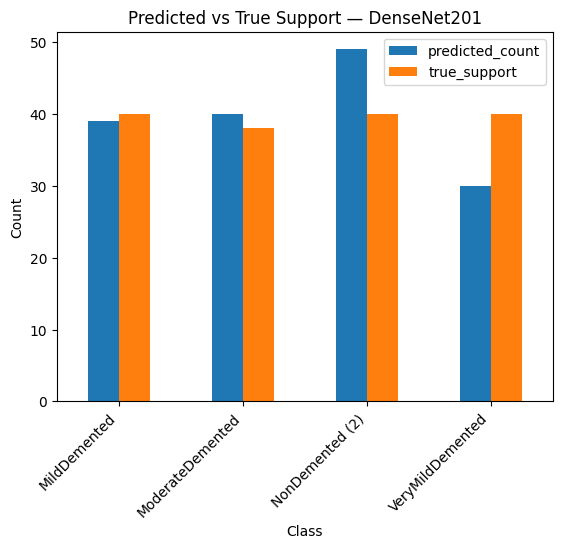

,predicted_count,true_support
MildDemented,0,40
ModerateDemented,0,38
NonDemented (2),0,40
VeryMildDemented,158,40


<Figure size 640x480 with 0 Axes>

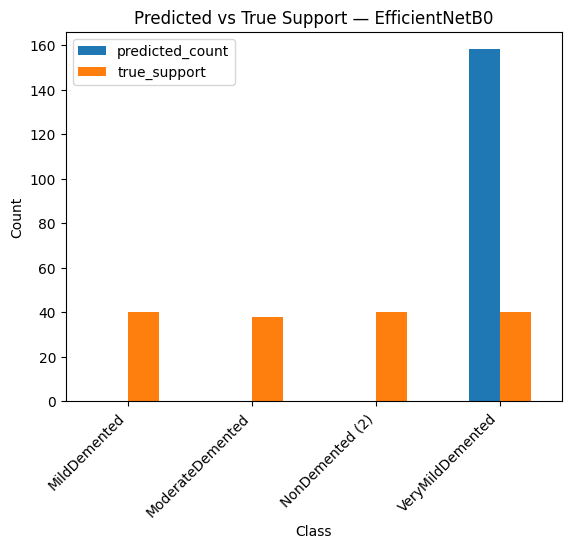

,predicted_count,true_support
MildDemented,49,40
ModerateDemented,41,38
NonDemented (2),43,40
VeryMildDemented,25,40


<Figure size 640x480 with 0 Axes>

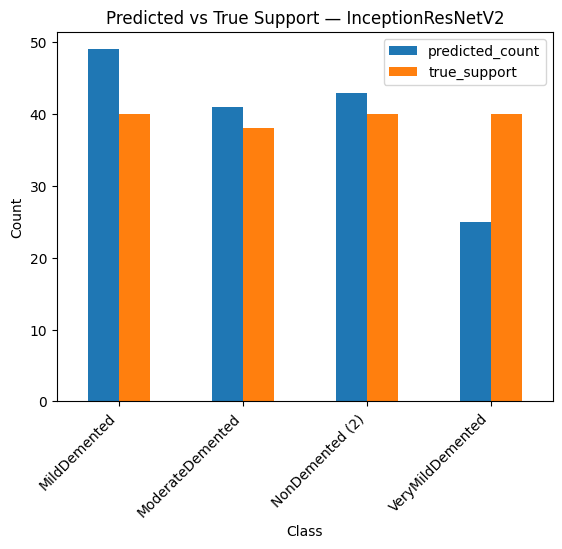

,predicted_count,true_support
MildDemented,45,40
ModerateDemented,42,38
NonDemented (2),43,40
VeryMildDemented,28,40


<Figure size 640x480 with 0 Axes>

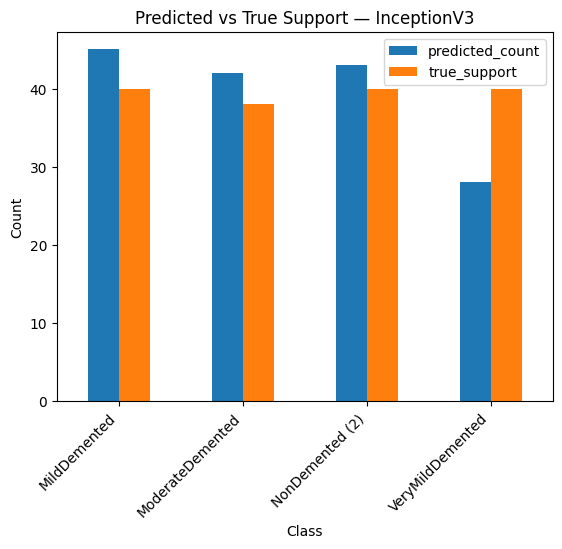

,predicted_count,true_support
MildDemented,40,40
ModerateDemented,41,38
NonDemented (2),47,40
VeryMildDemented,30,40


<Figure size 640x480 with 0 Axes>

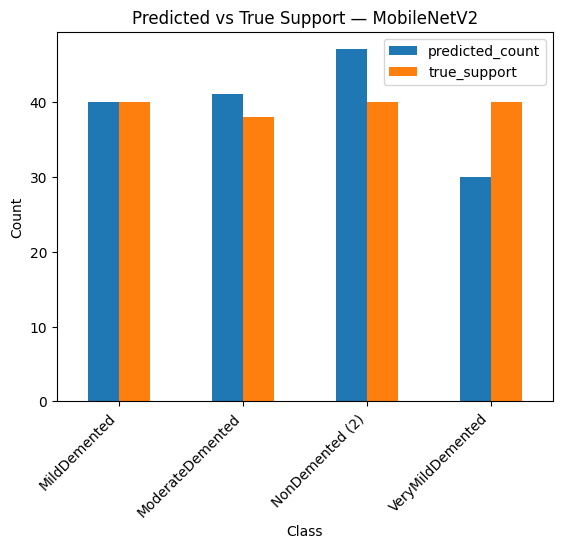

,predicted_count,true_support
MildDemented,38,40
ModerateDemented,41,38
NonDemented (2),43,40
VeryMildDemented,36,40


<Figure size 640x480 with 0 Axes>

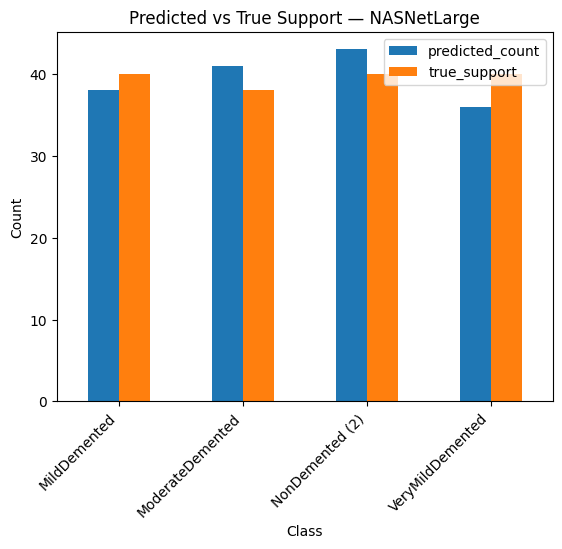

,predicted_count,true_support
MildDemented,56,40
ModerateDemented,14,38
NonDemented (2),56,40
VeryMildDemented,32,40


<Figure size 640x480 with 0 Axes>

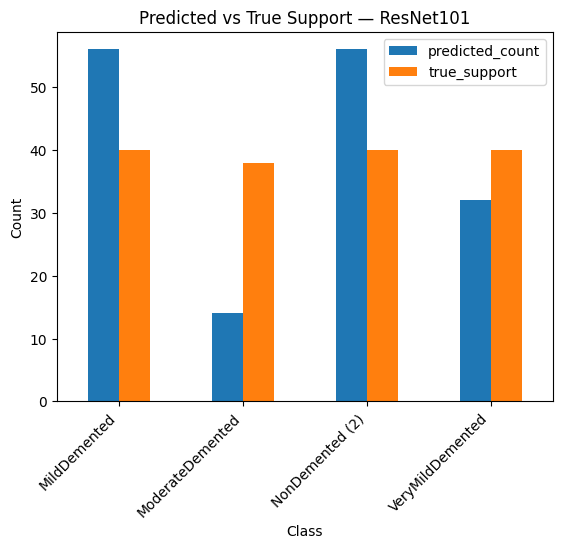

,predicted_count,true_support
MildDemented,46,40
ModerateDemented,25,38
NonDemented (2),80,40
VeryMildDemented,7,40


<Figure size 640x480 with 0 Axes>

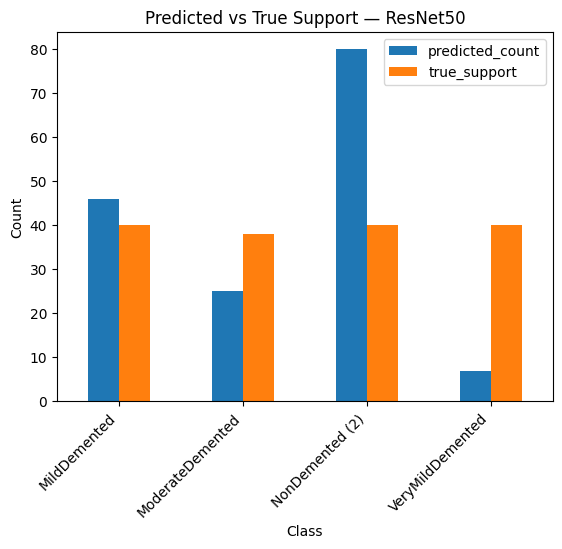

,predicted_count,true_support
MildDemented,39,40
ModerateDemented,38,38
NonDemented (2),40,40
VeryMildDemented,41,40


<Figure size 640x480 with 0 Axes>

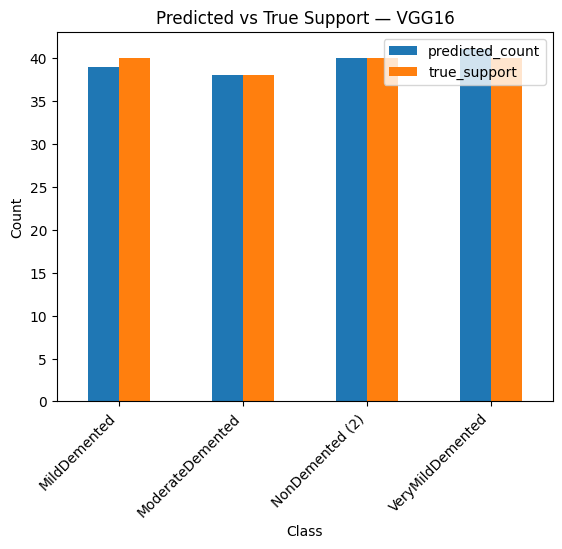

,predicted_count,true_support
MildDemented,38,40
ModerateDemented,38,38
NonDemented (2),64,40
VeryMildDemented,18,40


<Figure size 640x480 with 0 Axes>

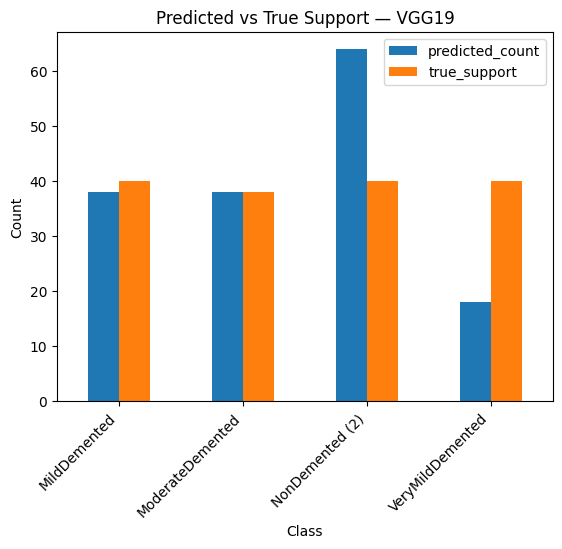

,predicted_count,true_support
MildDemented,46,40
ModerateDemented,42,38
NonDemented (2),36,40
VeryMildDemented,34,40


<Figure size 640x480 with 0 Axes>

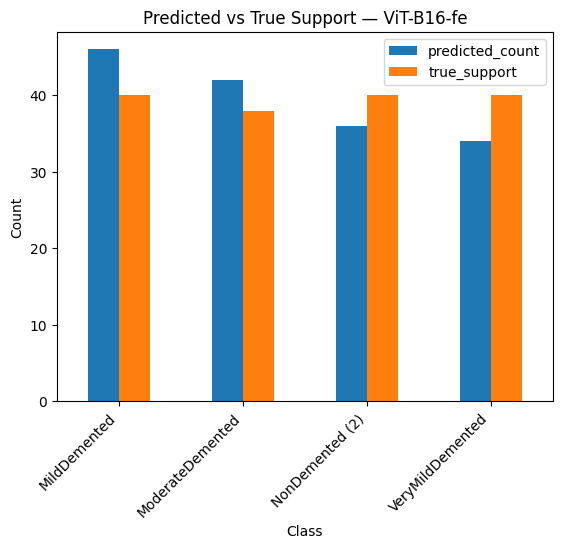

,predicted_count,true_support
MildDemented,41,40
ModerateDemented,43,38
NonDemented (2),41,40
VeryMildDemented,33,40


<Figure size 640x480 with 0 Axes>

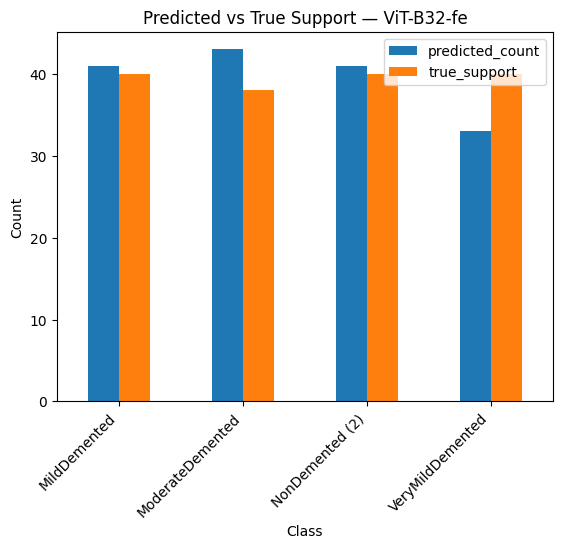

,predicted_count,true_support
MildDemented,48,40
ModerateDemented,40,38
NonDemented (2),40,40
VeryMildDemented,30,40


<Figure size 640x480 with 0 Axes>

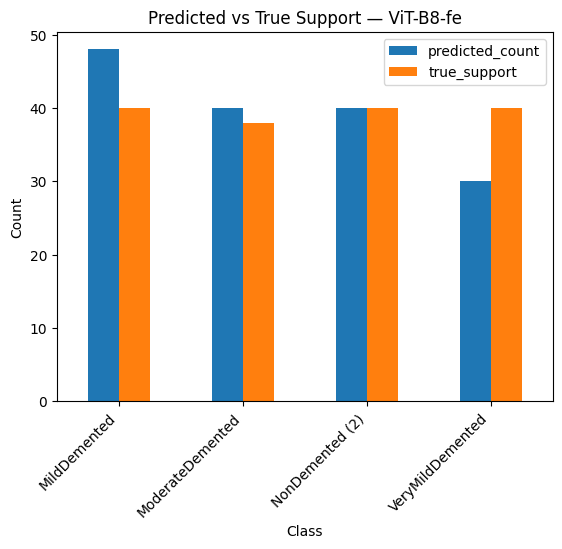

,predicted_count,true_support
MildDemented,47,40
ModerateDemented,37,38
NonDemented (2),32,40
VeryMildDemented,42,40


<Figure size 640x480 with 0 Axes>

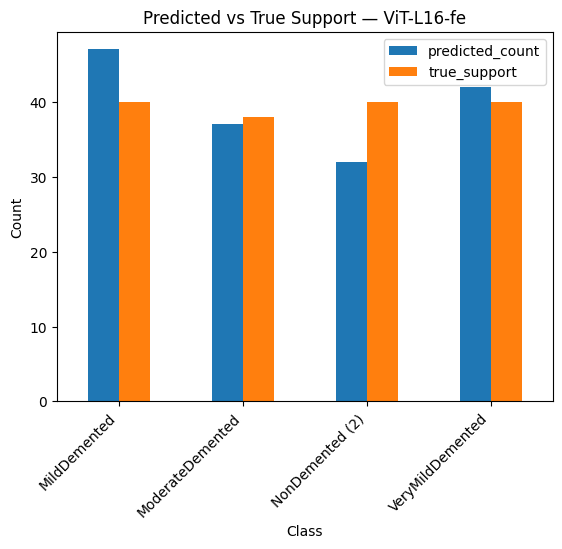

,predicted_count,true_support
MildDemented,43,40
ModerateDemented,37,38
NonDemented (2),44,40
VeryMildDemented,34,40


<Figure size 640x480 with 0 Axes>

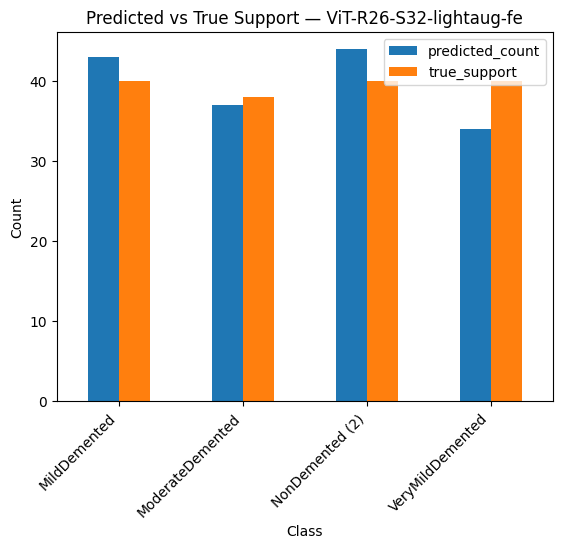

,predicted_count,true_support
MildDemented,46,40
ModerateDemented,44,38
NonDemented (2),45,40
VeryMildDemented,23,40


<Figure size 640x480 with 0 Axes>

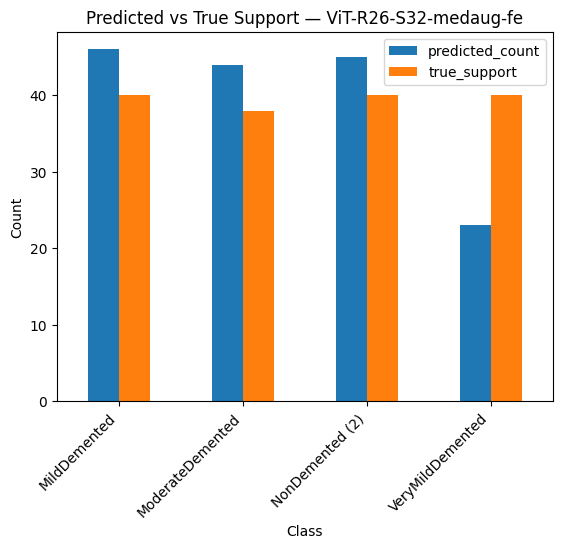

,predicted_count,true_support
MildDemented,35,40
ModerateDemented,44,38
NonDemented (2),43,40
VeryMildDemented,36,40


<Figure size 640x480 with 0 Axes>

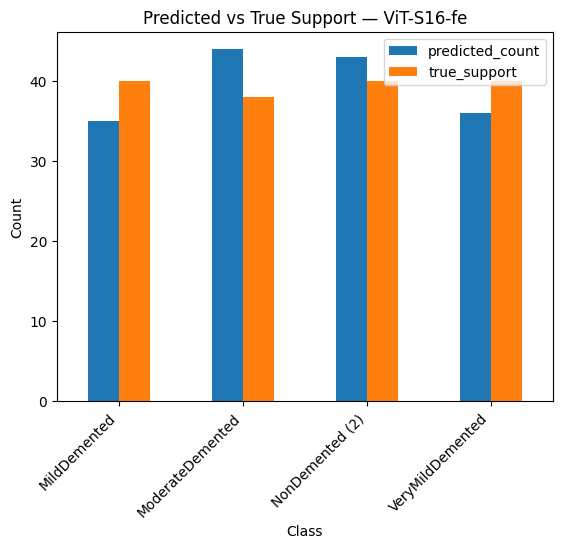

,predicted_count,true_support
MildDemented,57,40
ModerateDemented,39,38
NonDemented (2),36,40
VeryMildDemented,26,40


<Figure size 640x480 with 0 Axes>

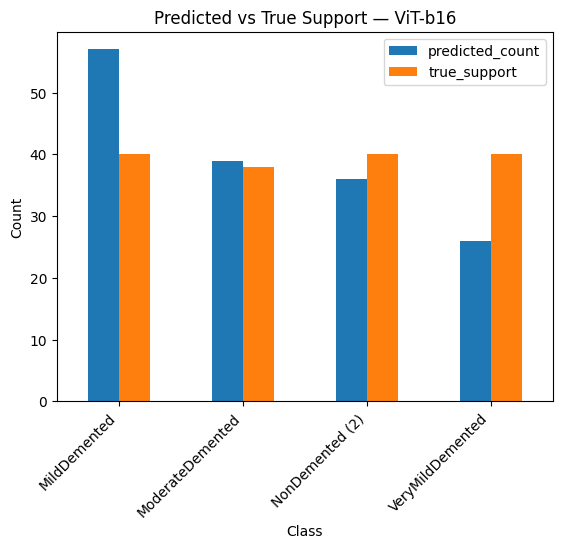

,predicted_count,true_support
MildDemented,35,40
ModerateDemented,43,38
NonDemented (2),38,40
VeryMildDemented,42,40


<Figure size 640x480 with 0 Axes>

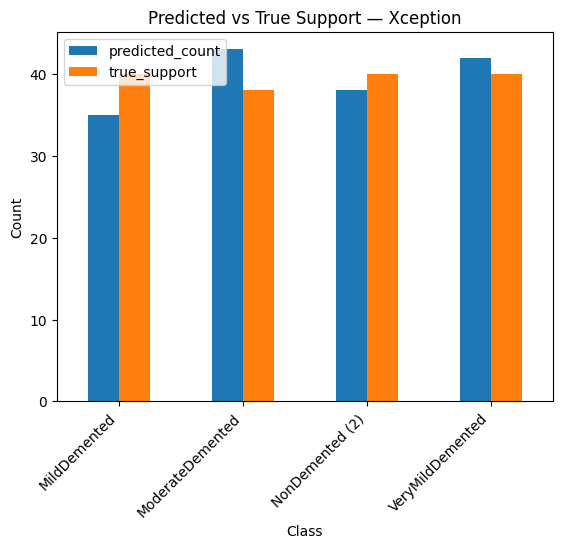

In [10]:

def plot_pred_vs_support(d):
    name = d.get("model_name") or os.path.basename(d.get("_file","unknown"))
    ev = d.get("evaluation_metrics", {})
    pred_dist = ev.get("prediction_distribution", {})
    cr = ev.get("classification_report_dict", {})
    # Build support dict from classification report (per-class entries only)
    true_support = {}
    for cls, vals in cr.items():
        if cls in ["accuracy","macro avg","weighted avg"]:
            continue
        supp = vals.get("support")
        if supp is not None:
            true_support[cls] = supp

    # Align keys
    all_classes = sorted(set(list(pred_dist.keys()) + list(true_support.keys())))
    pred_vals = [pred_dist.get(k, 0) for k in all_classes]
    supp_vals = [true_support.get(k, 0) for k in all_classes]

    df = pd.DataFrame({"predicted_count": pred_vals, "true_support": supp_vals}, index=all_classes)
    display(df)

    # One plot per model (no subplots)
    plt.figure()
    df.plot(kind="bar")
    plt.title(f"Predicted vs True Support — {name}")
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.xticks(rotation=45, ha="right")
    plt.legend()
    plt.show()

for d in metrics_data:
    plot_pred_vs_support(d)


## Error Analysis Notes

In [11]:

# If we save misclassification indices or per-sample predictions elsewhere,
# we could extend this section to load them and drill down into failure modes.
# Placeholders for future extensions:
# - Per-class confusion breakdown with normalized rates
# - Threshold sweeps (if probabilities are available)
# - Calibration plots (if probabilities are available)


## Appendix — Raw Classification Reports

In [12]:

for d in metrics_data:
    name = d.get("model_name") or os.path.basename(d.get("_file","unknown"))
    txt = d.get("evaluation_metrics", {}).get("classification_report_str")
    if txt:
        print(f"\n===== {name} =====")
        print(txt)
    else:
        print(f"[WARN] No classification_report_str for {name}")



===== DenseNet121 =====
                  precision    recall  f1-score   support

ModerateDemented       0.76      0.92      0.83        38
 NonDemented (2)       0.81      0.75      0.78        40
VeryMildDemented       0.50      0.45      0.47        40
    MildDemented       0.64      0.62      0.63        40

        accuracy                           0.68       158
       macro avg       0.68      0.69      0.68       158
    weighted avg       0.68      0.68      0.68       158


===== DenseNet201 =====
                  precision    recall  f1-score   support

ModerateDemented       0.95      1.00      0.97        38
 NonDemented (2)       0.67      0.82      0.74        40
VeryMildDemented       0.50      0.38      0.43        40
    MildDemented       0.69      0.68      0.68        40

        accuracy                           0.72       158
       macro avg       0.70      0.72      0.71       158
    weighted avg       0.70      0.72      0.70       158


===== Efficient

##  Model Ranking using Rule Based `Composite Score`

In [13]:
from sklearn.preprocessing import MinMaxScaler

def rank_models(df: pd.DataFrame) -> pd.DataFrame:
    if df.empty:
        print("No summary_df available to rank.")
        return df
    
    df_copy = df.copy()

    # Select metrics to rank on
    metrics_for_score = [
        "test_accuracy",
        "macro_precision", "macro_recall", "macro_f1",
        "weighted_precision", "weighted_recall", "weighted_f1",
        "best_val_accuracy",
        "final_train_accuracy"
    ]
    
    # Scale values 0–1 for fair comparison (ignore NaNs)
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(df_copy[metrics_for_score].fillna(0))
    df_scaled = pd.DataFrame(scaled, columns=[m+"_scaled" for m in metrics_for_score])

    # Composite score (weights can be adjusted)
    # More weight to test accuracy and macro_f1
    weights = {
        "test_accuracy_scaled": 0.3,
        "macro_f1_scaled": 0.2,
        "macro_precision_scaled": 0.1,
        "macro_recall_scaled": 0.1,
        "weighted_f1_scaled": 0.1,
        "weighted_precision_scaled": 0.05,
        "weighted_recall_scaled": 0.05,
        "best_val_accuracy_scaled": 0.05,
        "final_train_accuracy_scaled": 0.05
    }

    df_copy["composite_score"] = 0
    for col, w in weights.items():
        df_copy["composite_score"] += df_scaled[col] * w

    # Sort by composite score
    ranked = df_copy.sort_values(by="composite_score", ascending=False).reset_index(drop=True)
    ranked.insert(0, "rank", ranked.index + 1)
    
    # Show key metrics + composite score
    return ranked[
        ["rank", "model", "composite_score", "test_accuracy", "macro_f1", "weighted_f1", 
         "best_val_accuracy", "final_train_accuracy"]
    ]

ranked_models = rank_models(summary_df)
display(ranked_models)


,rank,model,composite_score,test_accuracy,macro_f1,weighted_f1,best_val_accuracy,final_train_accuracy
0,1,ViT-B8-fe,0.987020,0.759494,0.752358,0.749872,0.743671,0.833938
1,2,ViT-L16-fe,0.980790,0.746835,0.753696,0.751085,0.772152,0.813975
2,3,Xception,0.976374,0.753165,0.753360,0.751957,0.715190,0.780399
3,4,ViT-B16-fe,0.965009,0.740506,0.737052,0.734672,0.759494,0.882033
4,5,ViT-B32-fe,0.965001,0.740506,0.734399,0.731818,0.756329,0.924682
5,6,ViT-S16-fe,0.964437,0.740506,0.735502,0.733081,0.737342,0.924682
6,7,ViT-b16,0.936419,0.727848,0.720200,0.718137,0.718354,0.812160
7,8,NASNetLarge,0.935198,0.727848,0.726297,0.724275,0.689873,0.820327
8,9,MobileNetV2,0.918438,0.721519,0.713932,0.711432,0.731013,0.725953
9,10,DenseNet201,0.905542,0.715190,0.707012,0.703628,0.718354,0.709619


##  Model Ranking using PCA Based `Composite Score`

In [14]:
import json
import glob
import os
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Function to load all JSON metric files and extract summary info
def load_metrics(json_folder='metrics/'):
    files = glob.glob(os.path.join(json_folder, '*_metrics.json'))
    rows = []
    for f in files:
        data = json.load(open(f))
        ev = data.get('evaluation_metrics', {})
        cr = ev.get('classification_report_dict', {})
        macro = cr.get('macro avg', {})
        weighted = cr.get('weighted avg', {})
        tr_info = data.get('training_info', {})
        training_history = data.get('training_history', {})
        rows.append({
            'model': data.get('model_name', os.path.basename(f)),
            'test_accuracy': ev.get('test_accuracy'),
            'macro_precision': macro.get('precision'),
            'macro_recall': macro.get('recall'),
            'macro_f1': macro.get('f1-score'),
            'weighted_precision': weighted.get('precision'),
            'weighted_recall': weighted.get('recall'),
            'weighted_f1': weighted.get('f1-score'),
            'best_val_accuracy': tr_info.get('best_val_accuracy'),
            'final_train_accuracy': tr_info.get('final_train_accuracy'),
            'training_history': training_history,
            '_file': f
        })
    return pd.DataFrame(rows)

# Extract engineered features from training history dict
def extract_history_features(history_dict):
    def auc(arr): 
        if arr is None or len(arr) == 0:
            return 0.0
        return np.sum(arr)
    
    features = {}
    features['train_acc_auc'] = auc(history_dict.get('accuracy', []))
    features['val_acc_auc'] = auc(history_dict.get('val_accuracy', []))
    features['train_loss_auc'] = auc(history_dict.get('loss', []))
    features['val_loss_auc'] = auc(history_dict.get('val_loss', []))

    features['final_train_acc'] = history_dict.get('accuracy', [0])[-1] if len(history_dict.get('accuracy', [])) > 0 else 0.0
    features['final_val_acc'] = history_dict.get('val_accuracy', [0])[-1] if len(history_dict.get('val_accuracy', [])) > 0 else 0.0
    features['final_train_loss'] = history_dict.get('loss', [0])[-1] if len(history_dict.get('loss', [])) > 0 else 0.0
    features['final_val_loss'] = history_dict.get('val_loss', [0])[-1] if len(history_dict.get('val_loss', [])) > 0 else 0.0

    # Overfitting indicators
    features['val_train_acc_diff'] = features['final_train_acc'] - features['final_val_acc']
    features['val_train_loss_diff'] = features['final_val_loss'] - features['final_train_loss']

    return features

# Main procedure to load, extract features, run PCA, and rank models
def rank_models_with_pca(json_folder='metrics/'):
    # 1. Load metrics & training histories
    df_metrics = load_metrics(json_folder)

    if df_metrics.empty:
        print("No metric JSON files found in the given folder!")
        return None

    # 2. Extract history-based features and combine with metrics
    features_list = []
    for idx, row in df_metrics.iterrows():
        hist_features = extract_history_features(row['training_history'])
        combined = {**row.to_dict(), **hist_features}
        features_list.append(combined)

    feature_df = pd.DataFrame(features_list)

    # Drop non-numeric or identifier columns before scaling
    drop_cols = ['model', '_file', 'training_history']
    feature_df_clean = feature_df.drop(columns=drop_cols, errors='ignore')

    # 3. Normalize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(feature_df_clean.fillna(0))

    # 4. PCA: reduce to 1 component as composite performance score
    pca = PCA(n_components=1)
    pc1_scores = pca.fit_transform(X_scaled).flatten()

    # 5. Add composite score and rank
    df_metrics['composite_score'] = pc1_scores
    ranked_df = df_metrics.sort_values('composite_score', ascending=False).reset_index(drop=True)

    return ranked_df

ranked_models = rank_models_with_pca(json_folder='metrics/')
if ranked_models is not None:
    display(ranked_models[['model', 'composite_score', 'test_accuracy', 'macro_f1', 'final_train_accuracy', 'best_val_accuracy']])


,model,composite_score,test_accuracy,macro_f1,final_train_accuracy,best_val_accuracy
0,ViT-B32-fe,3.363279,0.740506,0.734399,0.924682,0.756329
1,ViT-B16-fe,3.338243,0.740506,0.737052,0.882033,0.759494
2,ViT-S16-fe,3.297701,0.740506,0.735502,0.924682,0.737342
3,ViT-B8-fe,3.131703,0.759494,0.752358,0.833938,0.743671
4,ViT-L16-fe,2.799830,0.746835,0.753696,0.813975,0.772152
5,ViT-b16,2.465443,0.727848,0.720200,0.812160,0.718354
6,Xception,2.354463,0.753165,0.753360,0.780399,0.715190
7,NASNetLarge,2.343322,0.727848,0.726297,0.820327,0.689873
8,ViT-R26-S32-lightaug-fe,1.868207,0.696203,0.693836,0.843013,0.693038
9,ViT-R26-S32-medaug-fe,1.652555,0.708861,0.689453,0.810345,0.667722


## Advanced Model Ranking